In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

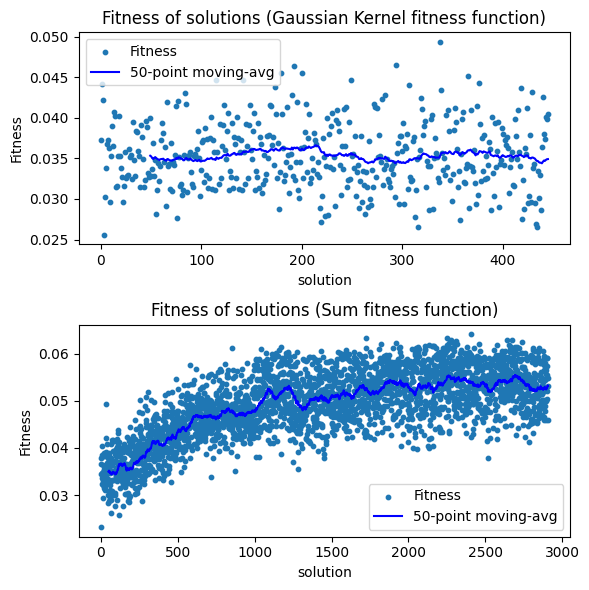

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_convergence = pd.read_csv('./solutions_fourth_07_08.csv')
df_convergence.dropna(inplace=True)
df_non_convergence = pd.read_csv('./solutions_third_31_07.csv')
df_non_convergence.dropna(inplace=True)

fig, axs = plt.subplots(2, figsize=(6, 6))

# Compute moving averages
ma_convergence = df_convergence['fitness'].rolling(window=50).mean()
ma_non_convergence = df_non_convergence['fitness'].rolling(window=50).mean()

# first plot for df_convergence
axs[1].scatter(df_convergence.index, df_convergence['fitness'], label='Fitness', s=10)
axs[1].plot(df_convergence.index, ma_convergence, color="blue", label='50-point moving-avg')

# second plot for df_non_convergence
axs[0].scatter(df_non_convergence.index, df_non_convergence['fitness'], label='Fitness', s=10)
axs[0].plot(df_non_convergence.index, ma_non_convergence, color="blue", label='50-point moving-avg')

# misc for first plot
axs[1].legend()
axs[1].set(xlabel='solution', ylabel='Fitness')
axs[1].set_title('Fitness of solutions (Sum fitness function)')

# misc for second plot
axs[0].legend()
axs[0].set(xlabel='solution', ylabel='Fitness')
axs[0].set_title('Fitness of solutions (Gaussian Kernel fitness function)')

# improve the spacing
plt.tight_layout()

# save as a png file
plt.savefig('convergence_comparison.png', dpi=600)


In [5]:
df_convergence['filename'] = df_convergence['solution'].apply(lambda x: x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace(' ',''))

In [6]:
df_convergence = df_convergence.head(10)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import scipy as sp
import cv2
import os

padding = 100
progress = 0

def generate_image(filename):
    global progress
    progress += 1
    if(progress%10 == 0):
        print('progress: ', progress)

        # Define the path where the image will be saved
    image_path = f"./images/{filename}.png"

    # Check if the image already exists
    if os.path.exists(image_path):
        return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image_representation = np.array([int(i) for i in filename]).reshape(11, 11)
    upscaled_image = sp.ndimage.zoom(image_representation, 200, order=0)
    
    # add padding zeros
    upscaled_image = np.pad(
        upscaled_image, [(padding, padding), (padding, padding)], mode="constant"
    )
    # use this to cut extrude
    inverted_image = np.logical_not(upscaled_image)

    # make integer value for cv2
    upscaled_image_uint8 = (inverted_image * 255).astype(np.uint8)


    # calculate the kernel size to achieve the desired fillet radius
    fillet_radius = 11  # radius in nm
    image_size = np.size(
        upscaled_image_uint8[0]
    )  # number of pixels on one side of the image
    substrate_size = 500  # nm, the sidelength of our simulation boundaries

    pixel_per_nm = image_size / substrate_size
    kernel_size = int(2 * fillet_radius * pixel_per_nm)
    # create the structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # dilate and then erode the image
    rounded_image = cv2.morphologyEx(upscaled_image_uint8, cv2.MORPH_OPEN, kernel)
    rounded_image = cv2.morphologyEx(rounded_image, cv2.MORPH_CLOSE, kernel)

    # Save the generated image
    cv2.imwrite(image_path, rounded_image)

    return rounded_image.astype(np.uint8)

# This will store the handle for the red point, allowing us to remove it in the next frame
fitness_text = None  # This will store the handle for the fitness text
current_point = None

# Update function for the animation
def update(frame):
    global current_point, fitness_text

    # Generate the image for the current frame
    filename = df_convergence['filename'].iloc[frame]
    img = generate_image(filename).astype(np.uint8)  # Ensure the correct data type here
    im_display.set_array(img)
    
    # Remove the previously plotted red point
    if current_point:
        current_point.remove()

    # Plot the current scatter point in red
    x = df_convergence.index[frame]
    y = df_convergence['fitness'].iloc[frame]
    current_point, = ax1.plot(x, y, 'ro')

    # Display the fitness below the image
    if fitness_text:
        fitness_text.remove()
    fitness_text = ax0.text(0.5, -0.1, f"Fitness: {y:.4f}", ha='center', transform=ax0.transAxes, size="large")

    return im_display, current_point

# Compute moving averages
ma_convergence = df_convergence['fitness'].rolling(window=50).mean()

# Create a figure with custom gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5], height_ratios=[1])  # Adjust width_ratios

# Initialize the image on the left side
ax0 = plt.subplot(gs[0])  # Image in the first column
initial_filename = df_convergence['filename'].iloc[0]
initial_image = generate_image(initial_filename)
im_display = ax0.imshow(initial_image, cmap="binary_r")
ax0.axis('off')

# Initialize the scatter plot on the right side
ax1 = plt.subplot(gs[1])  # Scatter plot in the second column
scatter = ax1.scatter(df_convergence.index, df_convergence['fitness'], label='Fitness', s=10, color='blue')
line, = ax1.plot(df_convergence.index, ma_convergence, color="blue", label='50-point moving-avg')
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3)

# Misc settings for the scatter plot
ax1.legend()
ax1.set_xlabel('Solution')
ax1.set_ylabel('Fitness')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(df_convergence), blit=True)

# Save the animation
ani.save('animated_figure.mp4', writer='ffmpeg', fps=10)

plt.show()

progress:  10
